In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, t

# Exercise 1:

# Exercise 2:

$$f(x) = \frac{e^{-x^2/2}}{\sqrt{2\pi}}$$
$$f(x) = \alpha e^{-|x|}$$

__1) for g to be a density function:__  
$$\int \alpha e^{-|x|} dx = 1$$
$$\int_{-\infty}^0 \alpha e^{x} dx + \int_{0}^{\infty} \alpha e^{-x} dx = 1$$
$$\alpha (e^x\Big|_{-\infty}^0 - e^{-x}\Big|_0^{\infty}) = \alpha((1 - 0) - (0 - 1)) = 2\alpha= 1$$
$$\alpha = \frac{1}{2}$$

So,
$$g(x) = \frac{1}{2} e^{-|x|}$$
$$G(x) = \int_{-\infty}^x \frac{1}{2} e^{-|t|} dt = \begin{cases} \frac{1}{2}e^x, & x \le 0 \\ 1 - \frac{1}{2}e^{-x}, & x \gt 0 \end{cases}$$

__2) We can use ICDF method to draw from g:__
$$G^{-1}(y) = \begin{cases} ln(2y), & y \le 0.5 \\ -ln(2 - 2y), & y \gt 0.5 \end{cases}$$

In [2]:
def sample_distribution(sampling_size, distribution_icdf_func, icdf_func_paras, random_seed = 0):
    """Sampling the target distribution using its inverse cdf

    Keyword arguments:
    sampling_size -- sampling size
    distribution_icdf_func -- inverse cdf function of the target distribution p -> x
    icdf_func_paras -- dictionary of distribution_icdf_func parameters    
    random_seed -- for reproducible purpose
    
    Returns: 
    distribution_sampling: sampling array of the target distribution
    """
    np.random.seed(random_seed) # for reproduce purpose
    uniform_sampling = np.random.rand(sampling_size) # sampling uniform distribution
    distribution_sampling = distribution_icdf_func(uniform_sampling, **icdf_func_paras) # sampling with provided inverse cdf
    return distribution_sampling
    
def plot_distribution_histogram(sampling, distribution_pdf_func, pdf_func_paras, range=(-10, 10)):
    plt.hist(sampling, density=True, range=range, bins=100, edgecolor='black')
    plt.xlabel('x')
    plt.ylabel('P(x)')
    
    xs = np.linspace(range[0],range[1],1000)
    f_x = distribution_pdf_func(xs, **pdf_func_paras)
    plt.plot(xs, f_x)

    plt.show()
    
sampling_size = 1000000

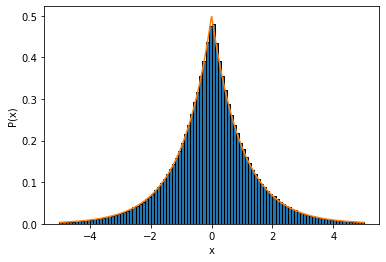

In [3]:
def g_pdf(x_val):    
    f_val = 0.5 * np.exp(-np.abs(x_val))
    return f_val

def g_inverse_cdf(p_val):    
    x_val = np.log(2*p_val)
    x_val[p_val > 0.5] = - np.log(2 - 2*p_val[p_val > 0.5])
    return x_val

g_sampling = sample_distribution(sampling_size, g_inverse_cdf, {})
plot_distribution_histogram(g_sampling, g_pdf, {}, range=(-5, 5))

__3) Sample $Y = \epsilon Z$__  

With:
$$P(\epsilon = -1) = P(\epsilon = 1) = 1/2$$
$$Z \sim Exp(1)$$

Steps:  
1. Sample Z according to Exp(1)  
2. For each z, draw $U \sim U[0,1]$  
2.1. If U < 0.5, z = -z  
2.2. If U > 0.5, z = z

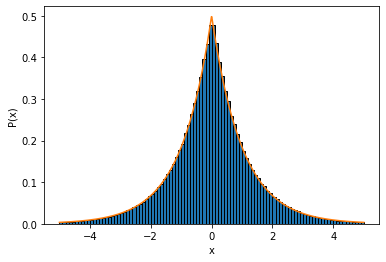

In [4]:
def exponential_pdf(x_val, lambda_val):    
    f_val = lambda_val * np.exp(-lambda_val * x_val)
    return f_val

def exponential_inverse_cdf(p_val, lambda_val):    
    x_val = - np.log(1 - p_val) / lambda_val
    return x_val

def binomial_inverse_cdf(p_val):    
    x_val = np.array([-1 if p <= 0.5 else 1 for p in p_val])    
    return x_val

paras = {'lambda_val': 1}

exponential_sampling = sample_distribution(sampling_size, exponential_inverse_cdf, paras, 0)

binomial_sampling = sample_distribution(sampling_size, binomial_inverse_cdf, {}, 1)

y_sampling = exponential_sampling * binomial_sampling

plot_distribution_histogram(y_sampling, g_pdf, {}, range=(-5, 5))

__4) Draw $X \sim N(0,1)$ by rejection method__  

In [5]:
def rejection_sampling(n_samples, target_distribution_pdf, target_distribution_parameters, 
                        proposal_distribution_pdf, proposal_distribution_icdf, proposal_distribution_parameters,
                        proposal_distribution_constant, 
                        display=True, random_seed = 0):
    """Sampling the target distribution from a proposed distribution follow rejection sampling

    Keyword arguments:
    n_samples -- sampling size
    target_distribution_pdf -- pdf function of the target distribution x -> f(x)
    target_distribution_parameters -- dictionary of target_distribution_pdf parameters
    proposal_distribution_pdf -- pdf function of the propose distribution x -> g(x)
    proposal_distribution_icdf -- icdf function of the propose distribution x -> g(x)
    proposal_distribution_parameters -- dictionary of proposal_distribution_icdf parameters
    proposal_distribution_constant -- constant so that f(x) <= M g(x)
    display -- flag to display acceptance percentage
    random_seed -- for reproducible purpose
    
    Returns: 
    target_sampling: sampling array of the target distribution
    """
    # Initialize the sampling result array
    target_sampling = np.array([])
    sampled_size = 0
    
    # Sample until reach n_samples size
    while len(target_sampling) < n_samples:
        left = n_samples - len(target_sampling)
        sampling_batch_size = int(n_samples / 2)
        
        # Sampling from uniform distribution by batch
        np.random.seed(random_seed)
        uniform_sampling = np.random.rand(sampling_batch_size)
        
        # Sampling x from propose distribution's inverse cdf        
        xs = sample_distribution(sampling_batch_size, proposal_distribution_icdf, proposal_distribution_parameters, left)
        
        # Calculate ratio f(x) / M*g(x)
        g_xs = proposal_distribution_pdf(xs, **proposal_distribution_parameters)
        f_xs = target_distribution_pdf(xs, **target_distribution_parameters)
        fg_ratio = f_xs / (proposal_distribution_constant * g_xs)
        
        # Filter samples that can be accepted
        accepted_samples = xs[uniform_sampling <= fg_ratio]
        if len(accepted_samples) > left:
            accepted_samples = np.random.choice(accepted_samples, left, False)
        
        # Add accepted samples to sampling result array
        target_sampling = np.append(target_sampling, accepted_samples)
        sampled_size += sampling_batch_size
    
    if display:
        print("Sampling size:", len(target_sampling), '; Sampled size:', sampled_size, "; Accepted %:", len(target_sampling) / sampled_size)
    
    return target_sampling

def plot_pair_distribution(target_distribution_pdf_func, target_pdf_func_paras,
                           propose_distribution_pdf_func, propose_pdf_func_paras, 
                           proposal_distribution_constant = 1,
                           range=(-10, 10)):
    xs = np.linspace(range[0],range[1],1000)
    
    target_fx = target_distribution_pdf_func(xs, **target_pdf_func_paras)
    propose_fx = propose_distribution_pdf_func(xs, **propose_pdf_func_paras)
    
    plt.plot(xs, target_fx, label='target pdf')
    plt.plot(xs, proposal_distribution_constant * propose_fx, label='propose pdf * {}'.format(proposal_distribution_constant))
    
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('P(x)')
    plt.show()

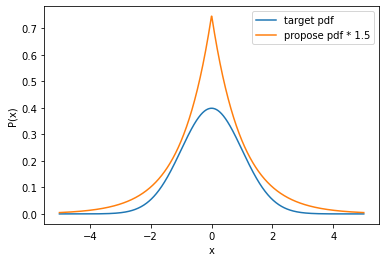

In [6]:
def gaussian_distribution_pdf(x):
    return np.exp(-(x**2)/2) / np.sqrt(2 * np.pi)

plot_pair_distribution(gaussian_distribution_pdf, {},
                        g_pdf, {}, 
                        proposal_distribution_constant = 1.5,
                        range=(-5, 5))

Sampling size: 1000000 ; Sampled size: 1500000 ; Accepted %: 0.6666666666666666


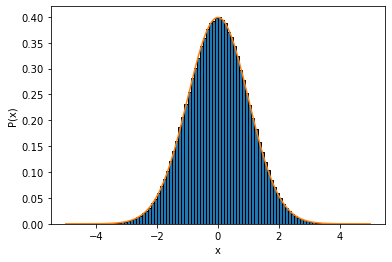

In [7]:
proposal_distribution_constant = 1.5

sampling = rejection_sampling(n_samples=sampling_size, 
                        target_distribution_pdf=gaussian_distribution_pdf, target_distribution_parameters={}, 
                        proposal_distribution_pdf=g_pdf, proposal_distribution_icdf=g_inverse_cdf, proposal_distribution_parameters={},
                        proposal_distribution_constant = proposal_distribution_constant)

plot_distribution_histogram(sampling, gaussian_distribution_pdf, {}, range=(-5, 5))

# Exercise 3:  

Estimation of Black Scholes formula

Give a 95% confidence interval of:
$$C = E[e^{-rT}(S_T - K)^+]$$

Where:
$$S_t = S_0 e^{(r- \sigma^2/2)t + \sigma B_t}$$
$$B_t \sim Brownian$$

In [8]:
def sample_brownian(n_samples, T, random_seed=0):
    X = np.array([0] * n_samples)
    gaussian_rv = norm(loc=0, scale=1)
    np.random.seed(random_seed)
    
    for i in range(1, T+1):
        ps = np.random.rand(n_samples)
        xs = gaussian_rv.ppf(ps)
        
        X = X + xs
        
    return X

Bt = sample_brownian(sampling_size, 2)
print('Mean and Var of Brownian motion:', np.mean(Bt), np.var(Bt))

Mean and Var of Brownian motion: 0.000949847837937593 2.0009891534047877


In [9]:
def sample_Black_Scholes(n_samples, S0, K, sigma, r, T, random_seed=0):
    Bt = sample_brownian(n_samples, T, random_seed)
    St = S0 * np.exp((r - sigma**2/2) * T + sigma * Bt)
    
    return St

def get_Black_Scholes_Confidence_Interval(n_samples, S0, K, sigma, r, T, alpha=0.05, random_seed=0):
    St = sample_Black_Scholes(n_samples, S0, K, sigma, r, T, random_seed)
    
    C = St - K
    C[C < 0] = 0
    C = np.exp(-r * T) * C
    
    t_alpha = t.isf(alpha/2, n_samples-1)
    C_mean, C_std = np.mean(C), np.std(C, ddof=1)
    n_sqrt = np.sqrt(sampling_size)
    CI = (C_mean - t_alpha * C_std / n_sqrt, C_mean + t_alpha * C_std / n_sqrt)
    
    return CI

CI = get_Black_Scholes_Confidence_Interval(n_samples=sampling_size, S0=20, K=25, sigma=1, r=0.05, T=3, alpha=0.05)
CI

(11.741286596307456, 12.093949653205913)